# Prediksi Model Subscription Deposito Berjangka 

In [3]:
import pandas as pd
import numpy as np
import sklearn
import imblearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

In [4]:
print("scikit-learn version:", sklearn.__version__)
print("imbalanced-learn version:", imblearn.__version__)

scikit-learn version: 1.2.2
imbalanced-learn version: 0.10.1


In [5]:
def ImportData(filename):
    """
    Fungsi yang digunakan untuk mengimport data dan menghapus duplikat
    :param filename: <string> nama file input dengan format .csv
    :return df: <pandas dataframe> sample data
    """
    
    #read data
    data = pd.read_csv(filename, sep=";")
    print("Data Asli            : ", data.shape, "- (#observasi, #kolom)")
    
    #drop duplicates
    data = data.drop_duplicates()
    print("Data setelah didrop  : ", data.shape, "- (#observasi, #kolom)")
    
    return data

def ExtractInputOutput (data, output_column_name):
    """
    Fungsi yang digunakan untuk memisahkan data input dan output 
    :param df: <pandas dataframe> data seluruh sample
    :param output_column_name: <string> nama column output
    :return input_data: <pandas dataframe> data input
    :return output_data: <pandas series> data output
    """
    
    #drop data
    output_data = data[output_column_name].astype("int")
    input_data = data.drop(output_column_name, axis = 1)
    
    return input_data, output_data

def ExtractCategorical(data, categorical_column):
    """
    Fungsi untuk melakukan ekstraksi data dari dat akategorikal dengan One Hot Encoding
    :param data : <pandas datframe> data sample
    :param categorical_cokumn: <list> list kolom kategorikal
    :return categorical_ohe: <pandas dataframe> data sample dengan ohe
    """
    
    data_categorical = data[categorical_column]
    categorical_ohe = pd.get_dummies(data_categorical).astype(int)
    return categorical_ohe

def StandardizerData(data):
    """
    Fungsi yang digunakan untuk melakukan standardisasi data
    :param data: <pandas dataframe> sample data
    :return standardize_data: <pandas dataframe> sample data standard
    :return standadizer: metode untuk standarisasi data
    """
    
    data_columns = data.columns # agar nama kolom tidak hilang
    data_index = data.index #agar index tidak hilang
    
    #Buat fit standardizer
    standardizer = StandardScaler()
    standardizer.fit(data)
    
    #Transfromasi data
    standardized_data_raw = standardizer.transform(data)
    standardized_data = pd.DataFrame(standardized_data_raw)
    standardized_data.columns = data_columns
    standardized_data.index = data_index
    
    return standardized_data, standardizer

def ExtractData(data, numerical_column, categorical_column, ohe_column, standardizer):
    """
    Fungsi untuk mengekstrak & membersihkan data 
    :param data: <pandas dataframe> sampel data
    :param numerical_column: <list> kolom numerik
    :param categorical_column: <list> kolom kategorik
    :param ohe_column: <list> kolom one-hot-encoding dari data kategorik
    :param standardizer: <sklearn method> standardizer data
    :return cleaned_data: <pandas dataframe> data final
    """
    # Filter data
    numerical_data = data[numerical_column]
    categorical_data = data[categorical_column]

    # Proses data numerik
    numerical_data.columns = numerical_column
    numerical_data.index = data.index

    # Proses data kategorik
    categorical_data = categorical_data.fillna(value="KOSONG")
    categorical_data.index = data.index
    categorical_data = pd.get_dummies(categorical_data)
    categorical_data.reindex(index = categorical_data.index, 
                             columns = ohe_column)

    # Gabungkan data
    concat_data = pd.concat([numerical_data, categorical_data],
                             axis = 1)
    cleaned_data = pd.DataFrame(standardizer.transform(concat_data))
    cleaned_data.columns = concat_data.columns

    return cleaned_data


class Model:
    """
    Class untuk menyimpan data-data performa setiap model yang dibuat.
    """
    def __init__(self, y_pred):
        """
        Fungsi inisialisasi untuk menyimpan performa model.
        :param y_pred: <pandas dataframe> output y hasil prediksi model
        """
        self.accuracy = 0
        self.precision = 0
        self.recall = 0
        self.f1 = 0
        self.y_pred = y_pred
        self.auc = 0
        
    def CheckAccuracy(self, y_true):
        """
        Fungsi untuk menghitung akurasi hasil prediksi jika dibandingkan dengan output seharusnya.
        :param y_true: <pandas dataframe> output yang seharusnya
        :param y_pred: <pandas datafram> output hasil prediksi
        """

        # Visualisasi Confusion Matrix
        confusion_matrix = metrics.confusion_matrix(y_true, self.y_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
        cm_display.plot()
        plt.xlabel("Prediction")
        plt.ylabel("Actual")
        plt.show()
        
        # Menghitung akurasi
        self.accuracy = np.round(accuracy_score(y_true, self.y_pred),2)
        self.precision = np.round(precision_score(y_true, self.y_pred),2)
        self.recall = np.round(recall_score(y_true, self.y_pred),2)
        self.f1 = np.round(f1_score(y_true, self.y_pred),2)
        
        # Menampilkan akurasi
        print("Accuracy:", self.accuracy)
        print("Precision:", self.precision)
        print("Recall:", self.recall)
        print("F1 score:", self.f1)
        return 
    
    
    def PrintAccuracy(self):
        """
        Fungsi untuk menampilkan seluruh data performa model.
        """
        print("Accuracy:", self.accuracy)
        print("Precision:", self.precision)
        print("Recall:", self.recall)
        print("F1 score:", self.f1)
        print("AUC:", self.auc)
    
    
    def PlotROC(self, y_true):
        """
        Fungsi untuk menampilkan visualisasi ROC Curve.
        :param y_true: output y yang seharusnya
        """
        fpr, tpr, thresholds = roc_curve(y_true, self.y_pred)
        self.auc = np.round(roc_auc_score(y_true, self.y_pred),2)
        
        plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % self.auc)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate (Recall)')
        plt.title('ROC Curve with AUC')
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.show()
    
    

# Trial 1 : Permodelan dengan Data Imbalance

## 1. Baca Data

In [6]:
df = ImportData("bank.csv")

Data Asli            :  (4521, 17) - (#observasi, #kolom)
Data setelah didrop  :  (4521, 17) - (#observasi, #kolom)


In [7]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


<Axes: title={'center': 'output'}, xlabel='y'>

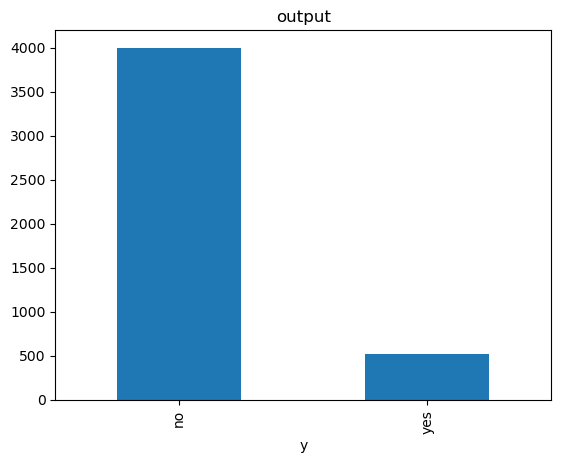

In [8]:
df.pivot_table(index="y", aggfunc="size").plot(kind='bar', title='output')

## 2. Data Cleaning

### 2.1 Missing Value

In [9]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

### 2.2. Tipe Data

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


### 2.3 Data Numerik

In [11]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


Mengganti data pdays  yang nilainya <0 menjadi 999

In [12]:
df.loc[df["pdays"]<0, "pdays"]=999
df["pdays"].describe()

count    4521.000000
mean      859.275603
std       301.892276
min         1.000000
25%       999.000000
50%       999.000000
75%       999.000000
max       999.000000
Name: pdays, dtype: float64

### 3. Pre-Processing Data

### 3.1 Mengubah Output menjadi Numerik

In [13]:
df.loc[df["y"]=="no", "y"] = 0
df.loc[df["y"]=="yes", "y"] = 1
df["y"] = df["y"].astype("int")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,999,0,unknown,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,999,0,unknown,0
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,999,0,unknown,0


### 3.2. Memisahkan Data Train dan Data Test

In [14]:
#Train Test Split
data_train, data_test = train_test_split(df, test_size = 0.20, random_state = 12)

#Ratio Check #harus sama dengan test_size
print("Ratio:", data_test.shape[0] / df.shape[0])
print("Dimensi Data Train:", data_train.shape)
print("Dimanesi Data Test:", data_test.shape)

Ratio: 0.20017695200176952
Dimensi Data Train: (3616, 17)
Dimanesi Data Test: (905, 17)


In [15]:
#Melakukan export Data Train ke Dalam Excel (Untuk Exploratory Data Analysis Via Tableau)
data_train.to_excel("data_train.xlsx", index=False)

## 3.3 Mengahapus kolom yang tidak digunakan

In [16]:
data_train.drop(["pdays", "default", "contact", "day", "month", "duration"], axis=1, inplace=True)
data_test.drop(["pdays", "default", "contact", "day", "month", "duration"], axis=1, inplace=True)
data_train.head()

,age,job,marital,education,balance,housing,loan,campaign,previous,poutcome,y
4043,39,services,divorced,secondary,282,yes,no,1,0,unknown,0
1458,36,management,married,tertiary,2987,yes,no,1,0,unknown,1
3655,44,management,married,tertiary,1242,yes,no,6,0,unknown,0
4413,65,retired,married,primary,493,no,no,1,1,failure,0
2154,36,blue-collar,married,secondary,63,yes,no,8,0,unknown,0


## 3.4 Memisahkan Input dan Output

In [17]:
#Memisahkan Input dan Output
x_train, y_train = ExtractInputOutput(data_train, "y")
x_test, y_test = ExtractInputOutput(data_test, "y")

#Sanity check hasil splitting
print("Data Training:", x_train.shape, y_train.shape)
print("Data Test:", x_test.shape, y_test.shape)

x_train

Data Training: (3616, 10) (3616,)
Data Test: (905, 10) (905,)


,age,job,marital,education,balance,housing,loan,campaign,previous,poutcome
4043,39,services,divorced,secondary,282,yes,no,1,0,unknown
1458,36,management,married,tertiary,2987,yes,no,1,0,unknown
3655,44,management,married,tertiary,1242,yes,no,6,0,unknown
4413,65,retired,married,primary,493,no,no,1,1,failure
2154,36,blue-collar,married,secondary,63,yes,no,8,0,unknown
...,...,...,...,...,...,...,...,...,...,...
3916,38,entrepreneur,married,tertiary,0,yes,no,3,0,unknown
1283,27,admin.,married,secondary,639,no,yes,3,0,unknown
3714,35,management,divorced,tertiary,434,yes,no,1,2,success
3325,28,blue-collar,single,secondary,416,yes,no,2,0,unknown


### 3.5. Preprocessing Categorical Variable

Data kategorikal:
- job
- marital
- education
- default
- housing
- loan
- poutcome

Data numerikal:
- age
- balance
- campaign
- pdays
- previous

In [18]:
# membuat tabel khusus data numerik
numerical_column = ["age", "balance", "campaign", "previous"]
x_train_numerical = x_train[numerical_column]

# membuat tabel khusus data kategorikal
x_train_column = list(x_train.columns)
categorical_column = list(set(x_train_column).difference(set(numerical_column)))

# Melakukan One-Hot Encoding untuk data kategorikal supaya menjadi data numerik
x_train_categorical_ohe = ExtractCategorical(x_train, categorical_column)
x_train_categorical_ohe.head()

,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,housing_no,housing_yes,loan_no,loan_yes,education_primary,education_secondary,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single
4043,0,0,0,1,0,1,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
1458,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3655,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4413,1,0,0,0,1,0,1,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2154,0,0,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [19]:
# menyimpan kolom OHE
ohe_columns = x_train_categorical_ohe.columns

# Sanity check
print(x_train_categorical_ohe.shape)

(3616, 27)


## 3.6. Menggabungkan Data Numerikal dan Kategorikal

In [20]:
x_train_concat = pd.concat([x_train_numerical, x_train_categorical_ohe], axis = 1)
x_train_concat.head()

,age,balance,campaign,previous,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,housing_no,housing_yes,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single
4043,39,282,1,0,0,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,0
1458,36,2987,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
3655,44,1242,6,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
4413,65,493,1,1,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2154,36,63,8,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0


In [21]:
#Mengecek missing value
x_train_concat.isna().sum()

age                    0
balance                0
campaign               0
previous               0
poutcome_failure       0
poutcome_other         0
poutcome_success       0
poutcome_unknown       0
housing_no             0
housing_yes            0
loan_no                0
loan_yes               0
education_primary      0
education_secondary    0
education_tertiary     0
education_unknown      0
job_admin.             0
job_blue-collar        0
job_entrepreneur       0
job_housemaid          0
job_management         0
job_retired            0
job_self-employed      0
job_services           0
job_student            0
job_technician         0
job_unemployed         0
job_unknown            0
marital_divorced       0
marital_married        0
marital_single         0
dtype: int64

Tidak ada missing value

## 3.7. Standardizing Variables

In [22]:
x_train_clean, standardizer = StandardizerData(data = x_train_concat)
x_train_clean.head()

,age,balance,campaign,previous,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,housing_no,housing_yes,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single
4043,-0.209847,-0.376825,-0.581556,-0.307870,-0.342679,-0.208755,-0.168646,0.459772,-0.869103,0.869103,...,-0.230881,-0.201434,3.155563,-0.128791,-0.45225,-0.172084,-0.091465,2.711280,-1.268443,-0.59822
1458,-0.498770,0.542726,-0.581556,-0.307870,-0.342679,-0.208755,-0.168646,0.459772,-0.869103,0.869103,...,-0.230881,-0.201434,-0.316901,-0.128791,-0.45225,-0.172084,-0.091465,-0.368829,0.788368,-0.59822
3655,0.271691,-0.050478,1.061853,-0.307870,-0.342679,-0.208755,-0.168646,0.459772,-0.869103,0.869103,...,-0.230881,-0.201434,-0.316901,-0.128791,-0.45225,-0.172084,-0.091465,-0.368829,0.788368,-0.59822
4413,2.294149,-0.305097,-0.581556,0.265088,2.918183,-0.208755,-0.168646,-2.174991,1.150612,-1.150612,...,4.331231,-0.201434,-0.316901,-0.128791,-0.45225,-0.172084,-0.091465,-0.368829,0.788368,-0.59822
2154,-0.498770,-0.451273,1.719217,-0.307870,-0.342679,-0.208755,-0.168646,0.459772,-0.869103,0.869103,...,-0.230881,-0.201434,-0.316901,-0.128791,-0.45225,-0.172084,-0.091465,-0.368829,0.788368,-0.59822


In [23]:
print(x_train_clean.dtypes)

age                    float64
balance                float64
campaign               float64
previous               float64
poutcome_failure       float64
poutcome_other         float64
poutcome_success       float64
poutcome_unknown       float64
housing_no             float64
housing_yes            float64
loan_no                float64
loan_yes               float64
education_primary      float64
education_secondary    float64
education_tertiary     float64
education_unknown      float64
job_admin.             float64
job_blue-collar        float64
job_entrepreneur       float64
job_housemaid          float64
job_management         float64
job_retired            float64
job_self-employed      float64
job_services           float64
job_student            float64
job_technician         float64
job_unemployed         float64
job_unknown            float64
marital_divorced       float64
marital_married        float64
marital_single         float64
dtype: object


In [24]:
print(x_test.dtypes)

age           int64
job          object
marital      object
education    object
balance       int64
housing      object
loan         object
campaign      int64
previous      int64
poutcome     object
dtype: object


In [25]:
# Check the shape of x_train_clean
print("Shape of x_train_clean:", x_train_clean.shape)

# Check the shape of x_test
print("Shape of x_test:", x_test.shape)

Shape of x_train_clean: (3616, 31)
Shape of x_test: (905, 10)


## 4. Training Machine Learning

### 4.1 Baseline

Baseline diambil dari proporsi kelas target yang paling besar. Kita akan menmprediksi hasil output marketing response dengan nilai "no" semua tanpa modelling

In [26]:
y_train.value_counts(normalize = True)

y
0    0.887168
1    0.112832
Name: proportion, dtype: float64

Maka baseline data training adalah 88%

In [27]:
y_train.value_counts(normalize = True)

y
0    0.887168
1    0.112832
Name: proportion, dtype: float64

Maka baseline data test adalah 87%

### 4.2. Fitting Model

Misal kita gunakan 3 model ML untuk klasifikasi:

    - K-Neares Neighbor (K-NN)
    - Logsitic Regression
    - Random Forest


#### a. Model K-Nearest Neighbor

In [28]:
#Model K-Nearest Neighbor
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train_clean, y_train)

KNeighborsClassifier(n_neighbors=3)

#### b. Model Logistic Regression

In [29]:
#Model LOgistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state = 123, class_weight='balanced')
logreg.fit(x_train_clean, y_train)

LogisticRegression(class_weight='balanced', random_state=123)

#### c. Model Random Forest

In [30]:
#Model Random Forest
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state = 1234, n_estimators = 30)
random_forest.fit(x_train_clean, y_train)

RandomForestClassifier(n_estimators=30, random_state=1234)

### 4.3. Menyiapkan Data Test

In [31]:
x_test = ExtractData(data = x_test, 
                    numerical_column = numerical_column,
                    categorical_column = categorical_column,
                    ohe_column = ohe_columns,
                    standardizer = standardizer)

x_test.head()

,age,balance,campaign,previous,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,housing_no,housing_yes,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single
0,0.849536,-0.472690,-0.252874,-0.307870,-0.342679,-0.208755,-0.168646,0.459772,1.150612,-1.150612,...,-0.230881,-0.201434,-0.316901,-0.128791,-0.452250,-0.172084,-0.091465,-0.368829,0.788368,-0.59822
1,1.716304,0.114396,0.404490,0.838046,2.918183,-0.208755,-0.168646,-2.174991,1.150612,-1.150612,...,-0.230881,-0.201434,-0.316901,-0.128791,-0.452250,-0.172084,-0.091465,-0.368829,0.788368,-0.59822
2,1.619996,-0.367647,-0.252874,-0.307870,-0.342679,-0.208755,-0.168646,0.459772,1.150612,-1.150612,...,-0.230881,-0.201434,-0.316901,-0.128791,-0.452250,-0.172084,-0.091465,-0.368829,0.788368,-0.59822
3,-0.498770,-0.542718,-0.252874,-0.307870,-0.342679,-0.208755,-0.168646,0.459772,-0.869103,0.869103,...,-0.230881,-0.201434,-0.316901,-0.128791,-0.452250,-0.172084,-0.091465,-0.368829,0.788368,-0.59822
4,1.138458,1.591457,0.404490,-0.307870,-0.342679,-0.208755,-0.168646,0.459772,1.150612,-1.150612,...,-0.230881,-0.201434,-0.316901,-0.128791,2.211165,-0.172084,-0.091465,-0.368829,0.788368,-0.59822


### 4.4. Evaluasi Model di Data Training dan Data Test

#### a. EValuasi Model KNN

In [32]:
# Check pandas version
import pandas as pd
print("pandas version:", pd.__version__)

# Check scikit-learn version
import sklearn
print("scikit-learn version:", sklearn.__version__)

pandas version: 2.0.3
scikit-learn version: 1.2.2


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Akurasi KNN di Data Training:


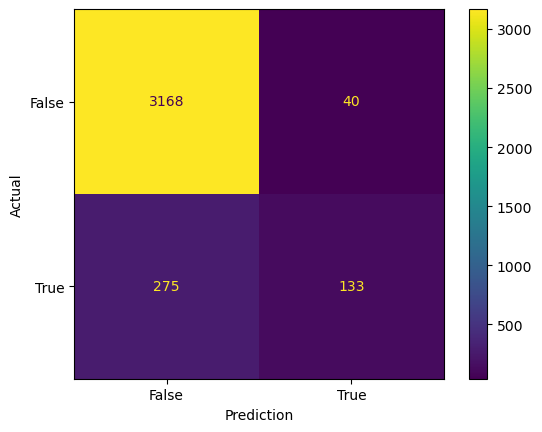

Accuracy: 0.91
Precision: 0.77
Recall: 0.33
F1 score: 0.46

Akurasi KNN di Data Test:


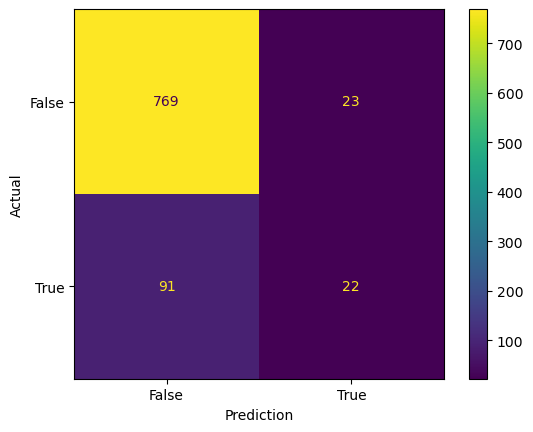

Accuracy: 0.87
Precision: 0.49
Recall: 0.19
F1 score: 0.28


In [33]:
#Prediksi KNN di Data Train
y_train_pred_knn = knn.predict(x_train_clean.values)

#Prediksi KNN di Data Test
y_test_pred_knn = knn.predict(x_test.values)

#Cek Akurasi
print("Akurasi KNN di Data Training:")
knn_train = Model(y_train_pred_knn)
knn_train.CheckAccuracy(y_train)
print("")
print("Akurasi KNN di Data Test:")
knn_test = Model(y_test_pred_knn)
knn_test.CheckAccuracy(y_test)

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Akurasi KNN di Data Training:


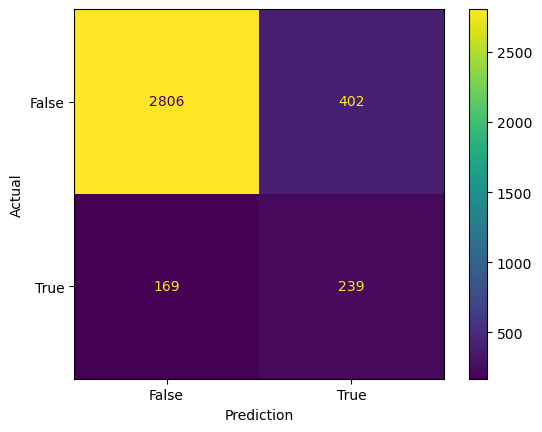

Accuracy: 0.84
Precision: 0.37
Recall: 0.59
F1 score: 0.46

Akurasi KNN di Data Test:


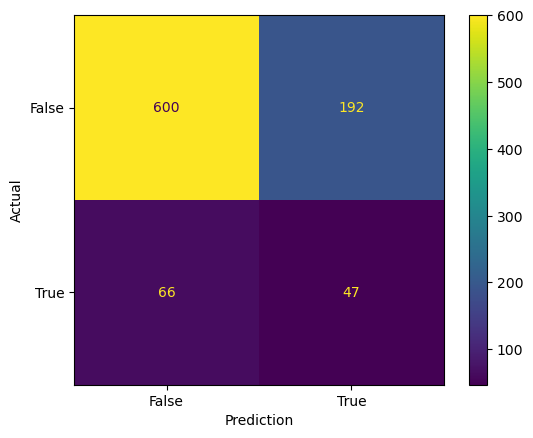

Accuracy: 0.71
Precision: 0.2
Recall: 0.42
F1 score: 0.27


In [60]:
#Prediksi KNN di Data Train
y_train_pred_knn = pd.DataFrame(knn.predict(x_train_clean.values))

#Prediksi KNN di Data Test
y_test_pred_knn = pd.DataFrame(knn.predict(x_test.values))

#Cek Akurasi
print("Akurasi KNN di Data Training:")
knn_train = Model(y_train_pred_knn)
knn_train.CheckAccuracy(y_train)
print("")
print("Akurasi KNN di Data Test:")
knn_test = Model(y_test_pred_knn)
knn_test.CheckAccuracy(y_test)

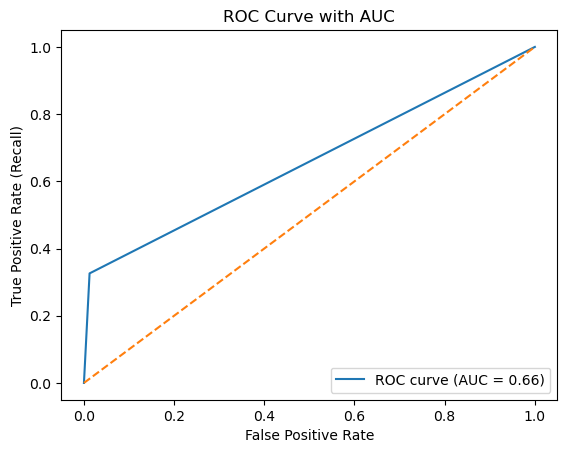

In [34]:
knn_train.PlotROC(y_train)

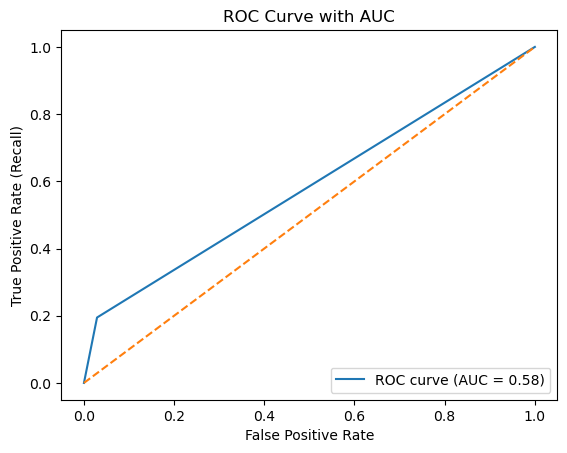

In [35]:
knn_test.PlotROC(y_test)

#### b. Evaluasi Model Logistic Regression

Akurasi LogReg di Data Training:


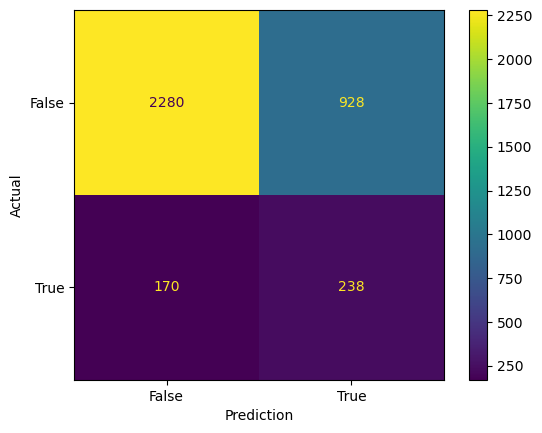

Accuracy: 0.7
Precision: 0.2
Recall: 0.58
F1 score: 0.3

Akurasi LogReg di Data Test:


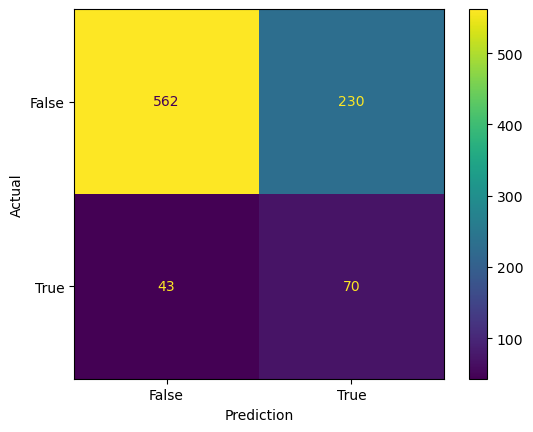

Accuracy: 0.7
Precision: 0.23
Recall: 0.62
F1 score: 0.34


In [36]:
# Prediksi LogReg di data training
y_train_pred_logreg = logreg.predict(x_train_clean)

# Prediksi LogReg di data test
y_test_pred_logreg = logreg.predict(x_test)

# Cek akurasi
print("Akurasi LogReg di Data Training:")
logreg_train = Model(y_train_pred_logreg)
logreg_train.CheckAccuracy(y_train)

print("")
print("Akurasi LogReg di Data Test:")
logreg_test = Model(y_test_pred_logreg)
logreg_test.CheckAccuracy(y_test)

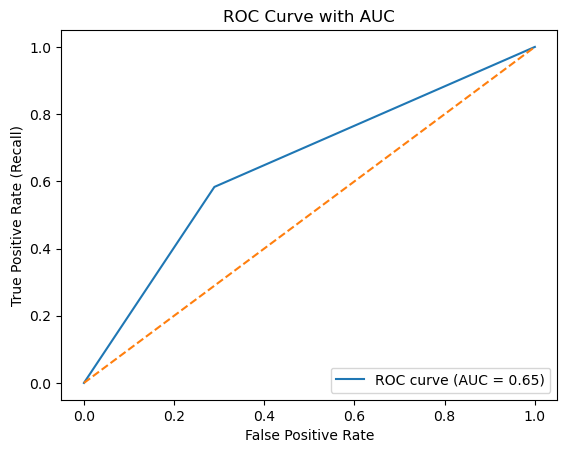

In [37]:
logreg_train.PlotROC(y_train)

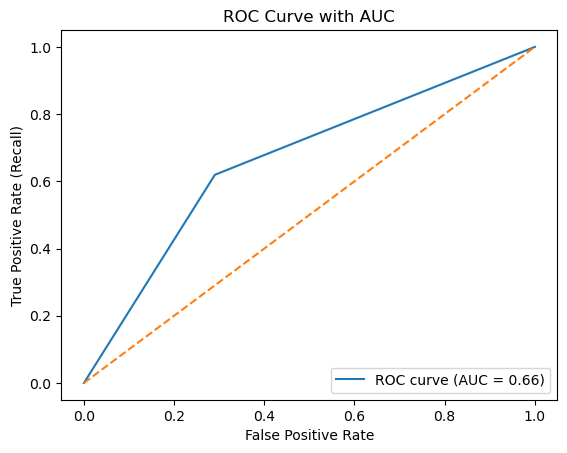

In [38]:
logreg_test.PlotROC(y_test)

#### c. Evaluasi Model Random Forest

Akurasi RF di Data Training:


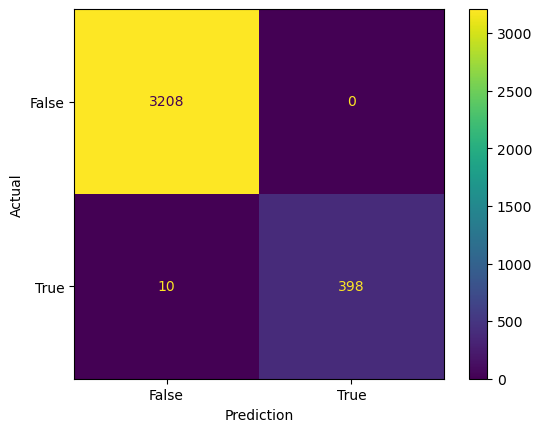

Accuracy: 1.0
Precision: 1.0
Recall: 0.98
F1 score: 0.99

Akurasi RF di Data Test:


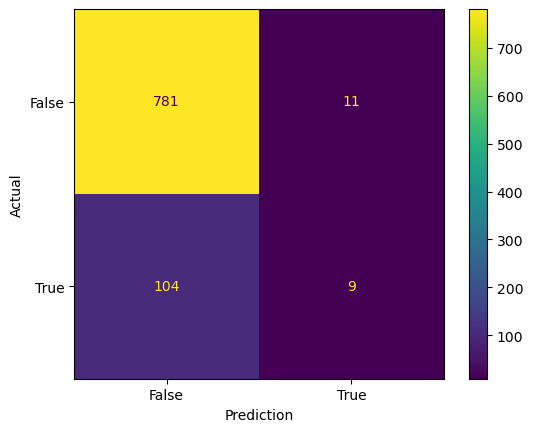

Accuracy: 0.87
Precision: 0.45
Recall: 0.08
F1 score: 0.14


In [39]:
# Prediksi Random Forest di data training
y_train_pred_rf = random_forest.predict(x_train_clean)

# Prediksi Random Forest di data test
y_test_pred_rf = random_forest.predict(x_test)

# Cek akurasi
print("Akurasi RF di Data Training:")
rf_train = Model(y_train_pred_rf)
rf_train.CheckAccuracy(y_train)

print("")
print("Akurasi RF di Data Test:")
rf_test = Model(y_test_pred_rf)
rf_test.CheckAccuracy(y_test)

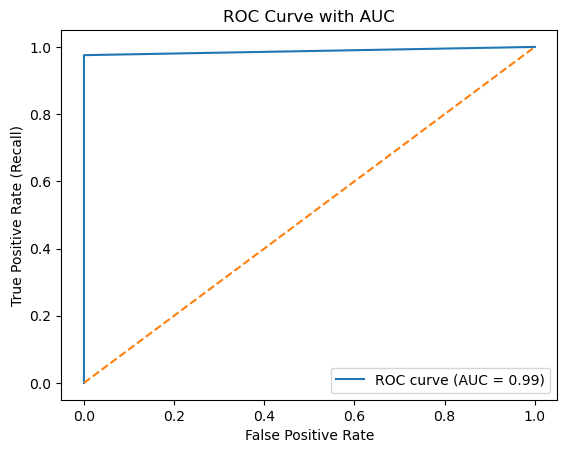

In [40]:
rf_train.PlotROC(y_train)

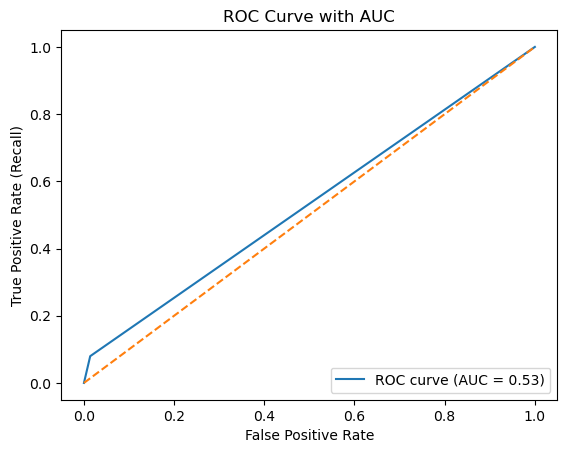

In [41]:
rf_test.PlotROC(y_test)

# Trial 2 : Oversample Data Imbalance

## 5. Data Argumentation

### 5.1 Cek Imbalance

<Axes: title={'center': 'Data Asli'}, xlabel='y'>

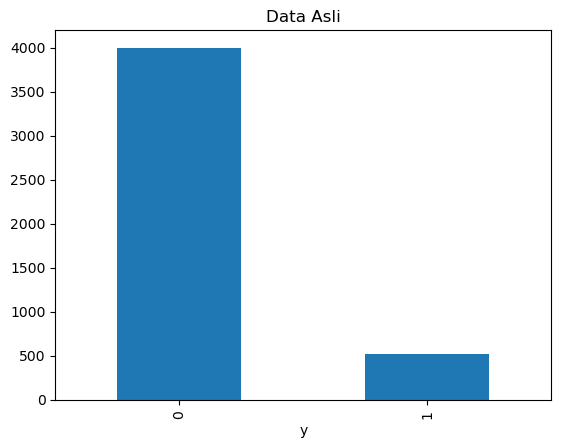

In [42]:
# Cek imbalance di data asli
df.pivot_table(index='y', aggfunc='size').plot(kind='bar', title='Data Asli')

<Axes: title={'center': 'Data Train'}, xlabel='y'>

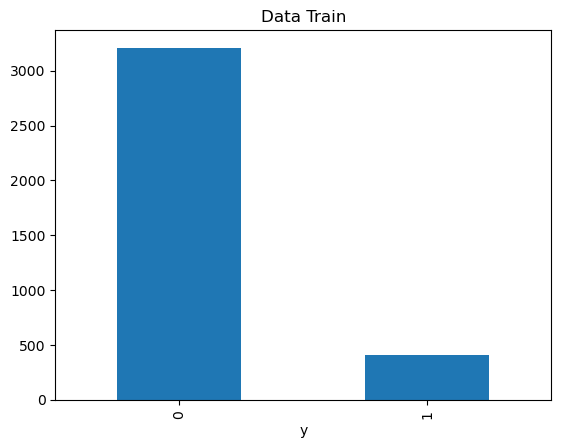

In [43]:
# Cek imbalance di data train
data_train.pivot_table(index='y', aggfunc='size').plot(kind='bar', title='Data Train')

Imbalance di data train sama dengan di data asli

<Axes: title={'center': 'Data Test'}, xlabel='y'>

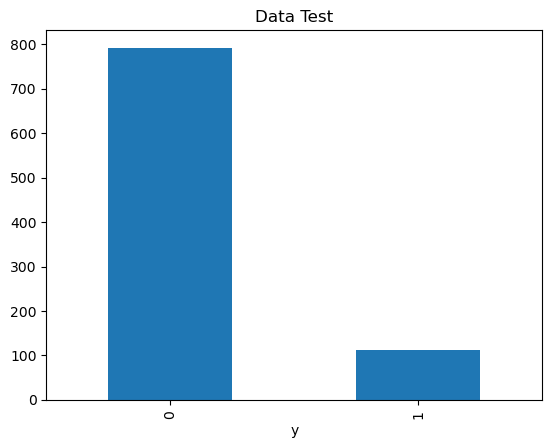

In [44]:
data_test.pivot_table(index='y', aggfunc='size').plot(kind='bar', title='Data Test')

Imbalance di Data Train sama dengan di Data Asli

### 5.2. Data Augmentation dengan SMOTE

In [45]:
data_train.head()

,age,job,marital,education,balance,housing,loan,campaign,previous,poutcome,y
4043,39,services,divorced,secondary,282,yes,no,1,0,unknown,0
1458,36,management,married,tertiary,2987,yes,no,1,0,unknown,1
3655,44,management,married,tertiary,1242,yes,no,6,0,unknown,0
4413,65,retired,married,primary,493,no,no,1,1,failure,0
2154,36,blue-collar,married,secondary,63,yes,no,8,0,unknown,0


<Axes: title={'center': 'Class distribution after appying SMOTENC'}, xlabel='y'>

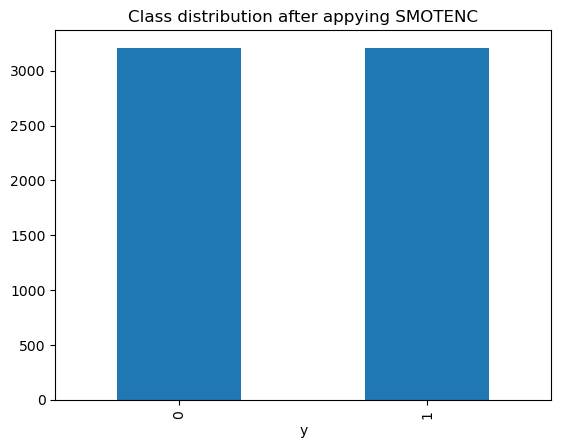

In [47]:
# Data augmentation dengan SMOTENC supaya balance
from imblearn.over_sampling import SMOTENC
sm = SMOTENC([1,2,3,5,6,9], random_state=123)
x_resampled, y_resampled = sm.fit_resample(x_train, y_train)
x_resampled = ExtractData(data = x_resampled,
                          numerical_column = numerical_column,
                          categorical_column = categorical_column,
                          ohe_column = ohe_columns,
                          standardizer = standardizer)

pd.Series(y_resampled).value_counts().plot(kind='bar', title='Class distribution after appying SMOTENC', xlabel='y')

## 6. Fitting Model dengan Data Resampled

Misal kita gunakan 3 model ML untuk klasifikasi:
    
- K-nearest neighbor (K-NN)
- Logistic Regression
- Random Forest

#### a. Model KNN

In [49]:
# Model K-Nearest Neighbor
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_resampled, y_resampled)

KNeighborsClassifier(n_neighbors=3)

#### b. Model Logistic Regression

In [50]:
# Model Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state = 123, class_weight="balanced")
logreg.fit(x_resampled, y_resampled)

LogisticRegression(class_weight='balanced', random_state=123)

#### c. Model Random FOrest

In [51]:
# Model Random Forest
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state = 1234, n_estimators = 30)
random_forest.fit(x_resampled, y_resampled)

RandomForestClassifier(n_estimators=30, random_state=1234)

## 7. Evaluasi Model di Data Train Resampled dan Data Test

#### a. Evaluasi Model KNN 

Akurasi KNN di Data Training:


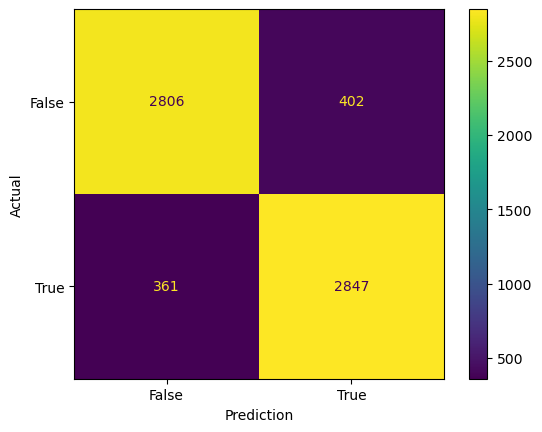

Accuracy: 0.88
Precision: 0.88
Recall: 0.89
F1 score: 0.88

Akurasi KNN di Data Test:


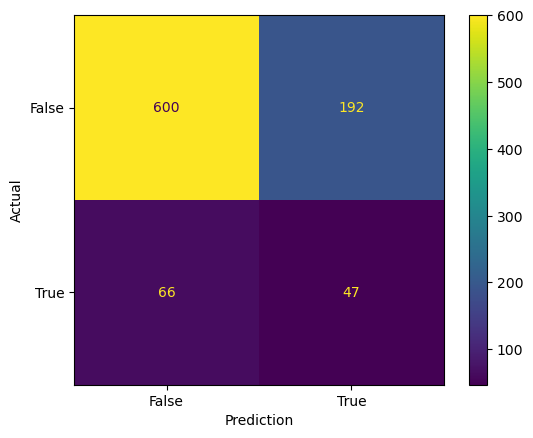

Accuracy: 0.71
Precision: 0.2
Recall: 0.42
F1 score: 0.27


In [53]:
# Prediksi KNN di data train
y_restrain_pred_knn = pd.DataFrame(knn.predict(x_resampled))

# Prediksi KNN di data test
y_restest_pred_knn = pd.DataFrame(knn.predict(x_test))

# Cek akurasi
print("Akurasi KNN di Data Training:")
knn_restrain = Model(y_restrain_pred_knn)
knn_restrain.CheckAccuracy(y_resampled)
print("")
print("Akurasi KNN di Data Test:")
knn_restest = Model(y_restest_pred_knn)
knn_restest.CheckAccuracy(y_test)

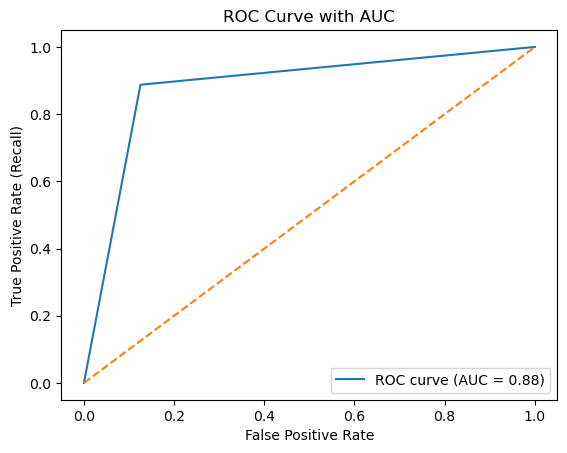

In [55]:
knn_restrain.PlotROC(y_resampled)

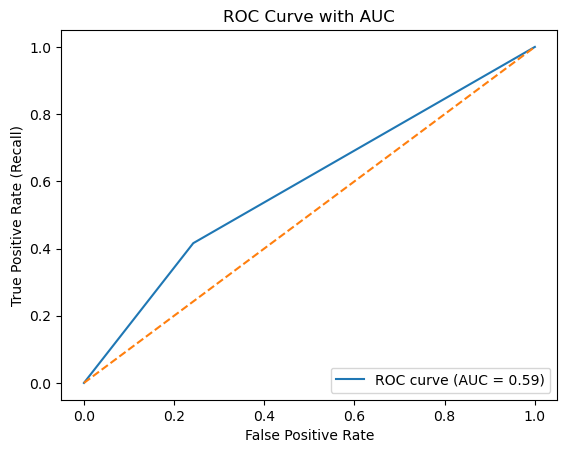

In [56]:
knn_restest.PlotROC(y_test)

#### b. EValusai Model Logistic Regression

Akurasi LogReg di Data Training:


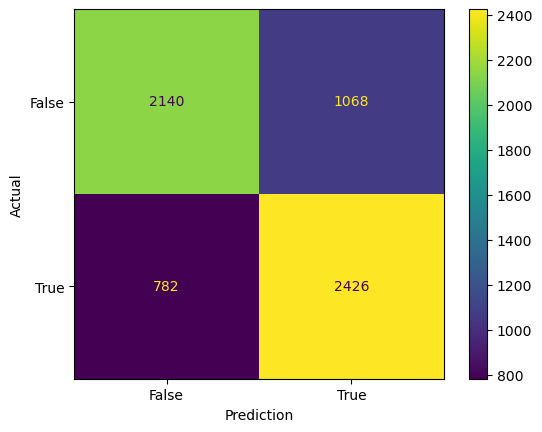

Accuracy: 0.71
Precision: 0.69
Recall: 0.76
F1 score: 0.72

Akurasi LogReg di Data Test:


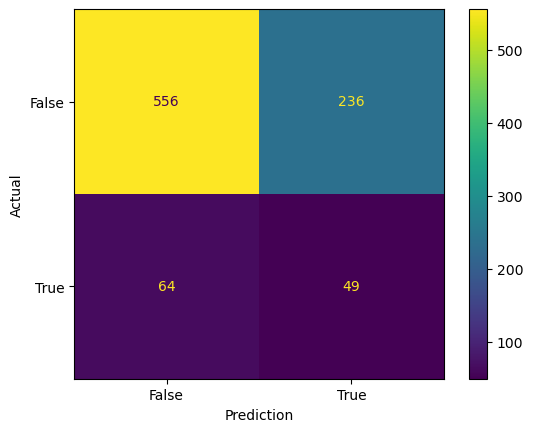

Accuracy: 0.67
Precision: 0.17
Recall: 0.43
F1 score: 0.25


In [59]:
# Prediksi LogReg di data training
y_restrain_pred_logreg = pd.DataFrame(logreg.predict(x_resampled))

# Prediksi LogReg di data test
y_restest_pred_logreg = pd.DataFrame(logreg.predict(x_test))

# Cek akurasi
print("Akurasi LogReg di Data Training:")
logreg_restrain = Model(y_restrain_pred_logreg)
logreg_restrain.CheckAccuracy(y_resampled)

print("")
print("Akurasi LogReg di Data Test:")
logreg_restest = Model(y_restest_pred_logreg)
logreg_restest.CheckAccuracy(y_test)

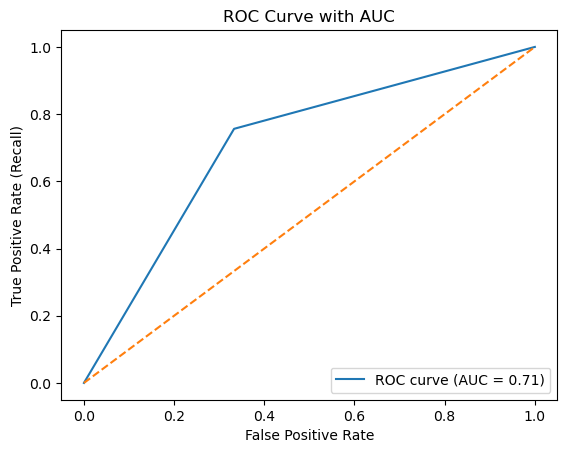

In [61]:
logreg_restrain.PlotROC(y_resampled)

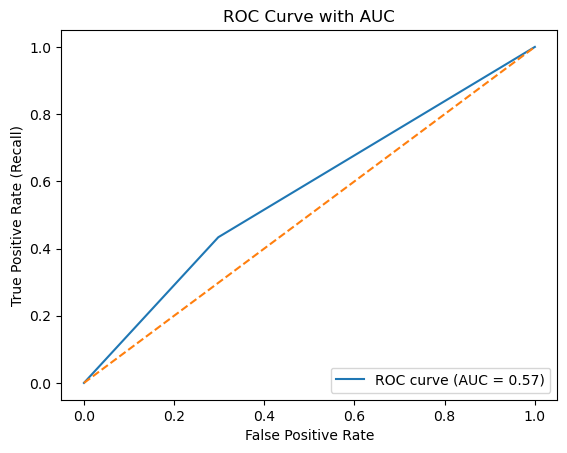

In [62]:
logreg_restest.PlotROC(y_test)

#### c. Evaluasi Model Random Forest

Akurasi RF di Data Training:


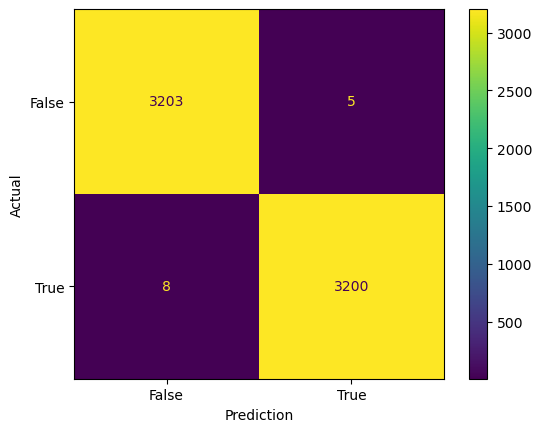

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0

Akurasi RF di Data Test:


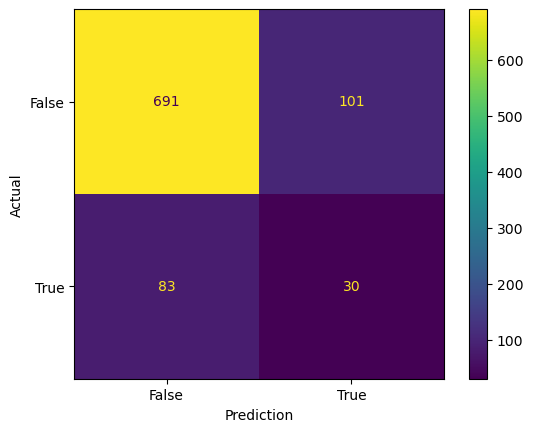

Accuracy: 0.8
Precision: 0.23
Recall: 0.27
F1 score: 0.25


In [63]:
# Prediksi Random Forest di data training
y_restrain_pred_rf = pd.DataFrame(random_forest.predict(x_resampled))

# Prediksi Random Forest di data test
y_restest_pred_rf = pd.DataFrame(random_forest.predict(x_test))

# Cek akurasi
print("Akurasi RF di Data Training:")
rf_restrain = Model(y_restrain_pred_rf)
rf_restrain.CheckAccuracy(y_resampled)

print("")
print("Akurasi RF di Data Test:")
rf_restest = Model(y_restest_pred_rf)
rf_restest.CheckAccuracy(y_test)

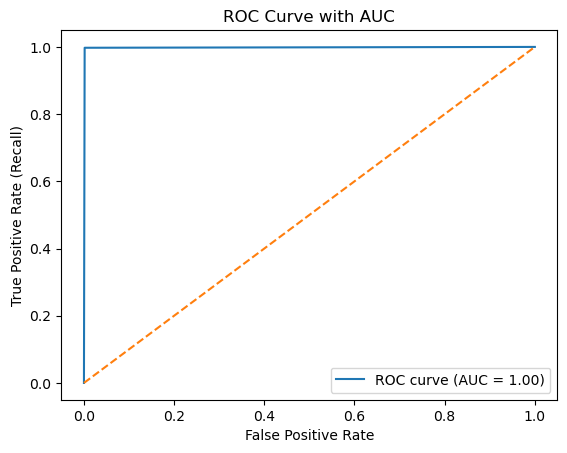

In [64]:
rf_restrain.PlotROC(y_resampled)

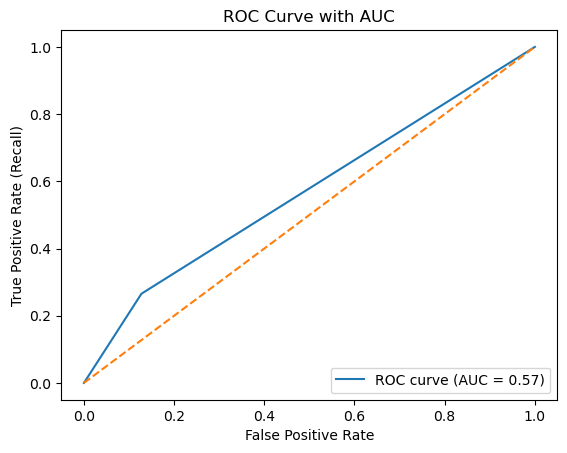

In [65]:
rf_restest.PlotROC(y_test)

## 8. Membandingkan Model

### 8.1 Performa di Data Test

In [66]:
# Rangkuman Akurasi

print("Accuracy")
print("KNN:", knn_test.accuracy)
print("KNN Resampled:", knn_restest.accuracy)
print("LogReg:", logreg_test.accuracy)
print("LogReg Resampled:", logreg_restest.accuracy)
print("RF:", rf_test.accuracy)
print("RF Resampled:", rf_restest.accuracy)

print("")
print("Recall")
print("KNN:", knn_test.recall)
print("KNN Resampled:", knn_restest.recall)
print("LogReg:", logreg_test.recall)
print("LogReg Resampled:", logreg_restest.recall)
print("RF:", rf_test.recall)
print("RF Resampled:", rf_restest.recall)

print("")
print("AUC")
print("KNN:", knn_test.auc)
print("KNN Resampled:", knn_restest.auc)
print("LogReg:", logreg_test.auc)
print("LogReg Resampled:", logreg_restest.auc)
print("RF:", rf_test.auc)
print("RF Resampled:", rf_restest.auc)

Accuracy
KNN: 0.71
KNN Resampled: 0.71
LogReg: 0.7
LogReg Resampled: 0.67
RF: 0.87
RF Resampled: 0.8

Recall
KNN: 0.42
KNN Resampled: 0.42
LogReg: 0.62
LogReg Resampled: 0.43
RF: 0.08
RF Resampled: 0.27

AUC
KNN: 0
KNN Resampled: 0.59
LogReg: 0.66
LogReg Resampled: 0.57
RF: 0.53
RF Resampled: 0.57


Pemilihan model dilakukan berdasarkan performa Recall dan AUC. Dapat disimpulkan model terbaik adalah Logistic Regression dengan data train asli tanpa dilakukan SMOTENC.

### 8.2. Performa Model Logistic Regression

In [68]:
print("Data Train")
logreg_train.PrintAccuracy()

print("")
print("Data Test")
logreg_test.PrintAccuracy()

Data Train
Accuracy: 0.7
Precision: 0.2
Recall: 0.58
F1 score: 0.3
AUC: 0.65

Data Test
Accuracy: 0.7
Precision: 0.23
Recall: 0.62
F1 score: 0.34
AUC: 0.66
